In [1]:
import json
import pathlib
import pycolmap

import numpy as np
import torch
from PIL import Image
from matplotlib import pyplot as plt

import neural_orientation_field.utils as utils
import neural_orientation_field.colmap.colmap_utils as colutils

In [2]:
# Use MPS device.
USE_DEVICE = "mps"

if USE_DEVICE == "mps" and torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

# Load Dataset

In [3]:
# Neural Orientation Field config
CONFIG_PATH = "../../../nof-config.json"
COLMAP_MODEL_PATH = "../../../data/cache/colmap/0/"

with open(CONFIG_PATH, "r") as config_file:
    config_dict = json.load(config_file)
project_config = utils.ProjectConfig.from_dict(config_dict)
image_dir = project_config.input_path
colmap_model_path = pathlib.Path(COLMAP_MODEL_PATH).resolve()

image_dir, colmap_model_path

(PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/images/iphone-cap-resize'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/cache/colmap/0'))

In [4]:
# Load COLMAP reconstruction
colmap_model = pycolmap.Reconstruction(colmap_model_path)
print(colmap_model.summary())

Reconstruction:
	num_reg_images = 41
	num_cameras = 41
	num_points3D = 5147
	num_observations = 23318
	mean_track_length = 4.53041
	mean_observations_per_image = 568.732
	mean_reprojection_error = 0.812827


In [5]:
num_images = colmap_model.num_reg_images()
cam_transforms, cam_params, image_file_names = colutils.get_camera_poses(colmap_model)
num_images, cam_transforms.shape, cam_params.shape, len(image_file_names)

(41, (41, 4, 4), (41, 3), 41)

In [6]:
# Split data.
shuffle_idx = np.arange(num_images)
np.random.shuffle(shuffle_idx)
num_train_images = int(num_images * 0.8)
train_idx, test_idx = np.split(shuffle_idx, [num_train_images])

train_idx, test_idx

(array([13, 24, 37, 19, 21,  1, 35, 25, 27, 34,  4,  2, 26, 31,  7, 33, 23,
         6, 39,  3, 30,  9, 36, 11,  5, 14, 20, 22, 17, 32, 18, 40]),
 array([38, 16,  0,  8, 10, 28, 15, 12, 29]))

In [7]:
nums_pixels_train = 0
images_train = []
cam_transform_train = []
cam_origs_train = []
cam_rays_train = []
for idx in train_idx:
    image = np.array(Image.open(image_dir / image_file_names[idx]))
    images_train.append(image)
    h, w, _ = image.shape
    f, cx, cy = cam_params[idx]
    cam_transform = cam_transforms[idx]
    cam_transform_inv = np.linalg.inv(cam_transform)
    cam_transform_train.append(cam_transform)
    # Calculate camera origins
    cam_orig = np.matmul(cam_transform, np.array([0, 0, 0, 1]))[:3]
    cam_origs_train.append(cam_orig)
    # Calculate camera ray.
    pixel_coord = np.moveaxis(np.mgrid[0:h, 0:w], 0, -1) - np.array([cx, cy])
    cam_ray_view = np.append(pixel_coord, f * np.ones((h, w, 1)), axis=2)
    cam_ray_homo = np.append(cam_ray_view, np.zeros((h, w, 1)), axis=2)
    cam_ray_world = np.matmul(
        cam_transform_inv[np.newaxis, np.newaxis, :, :],
        cam_ray_homo[:, :, :, np.newaxis]
    ).reshape((h, w, -1))[:, :, :3]
    cam_rays_train.append(cam_ray_world)

len(images_train), len(cam_transform_train), len(cam_origs_train), len(cam_rays_train)

(32, 32, 32, 32)

((856, 1142, 3), (3,), (3,), (856, 1142, 3))

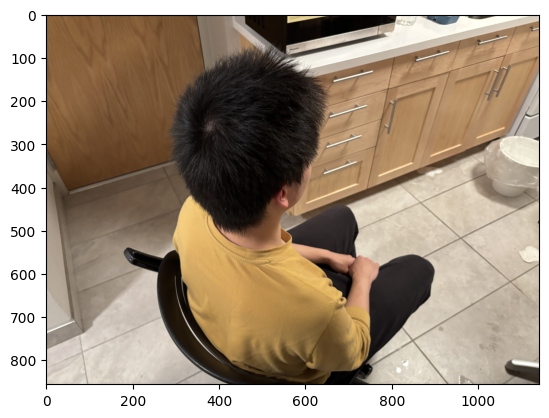

In [11]:
idx = 1
image = images_train[idx]
cam_transform = cam_origs_train[idx]
cam_orig = cam_origs_train[idx]
cam_ray = cam_rays_train[idx]
plt.imshow(image)
image.shape, cam_transform.shape, cam_orig.shape, cam_ray.shape

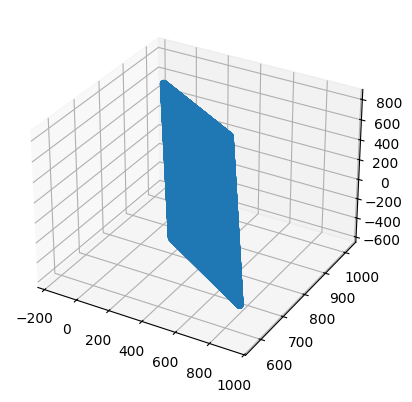

In [12]:
cam_ray_flatten = cam_ray.reshape(-1, 3)
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(cam_ray_flatten[:, 0], cam_ray_flatten[:, 1], cam_ray_flatten[:, 2])